# Test the neural network for different disorder Configurations

#### Imports

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn
from src.training.utils_analysis import test_models_unet

#### Data

In [35]:
hs=[2.4,3.6,5.44,7.2,8.4]
models_name=[f'2nn_ising/h_{h}_15k_unet_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock' for h in hs]
ls=[64]
data_path=[[f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_{h}_h_100_n.npz' for l in ls] for h in hs]

In [36]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i] for j in range(len(data_path[i]))],data_path=data_path[i])
    rs.append(r)
    des.append(de)
    devdes.append(devde)  

REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_4): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activati

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


#### Accuracy

$R^2$

1


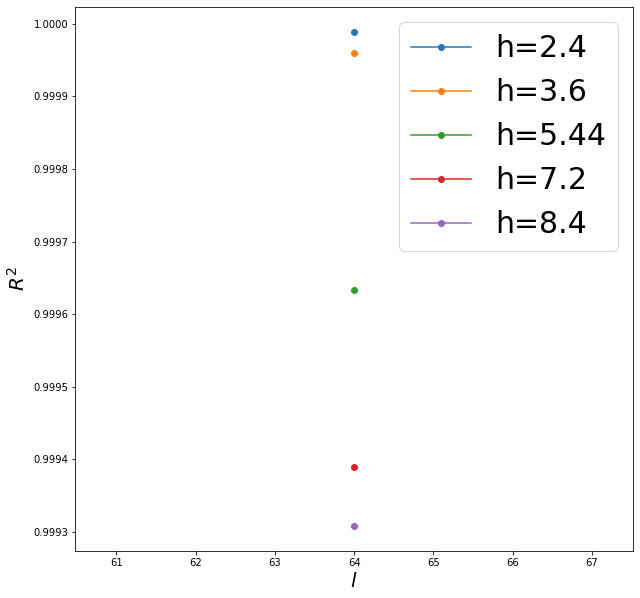

In [37]:
print(len(rs[i]))
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'h={hs[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

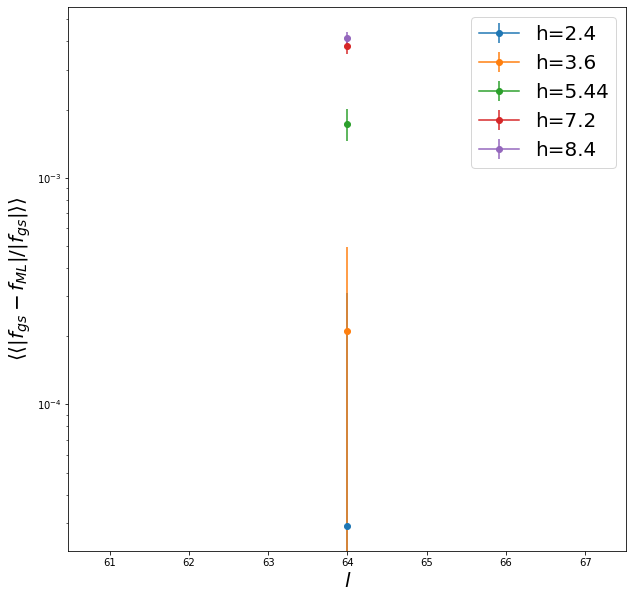

In [38]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'h={hs[i]}')
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [39]:
ndata=100
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[j][i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

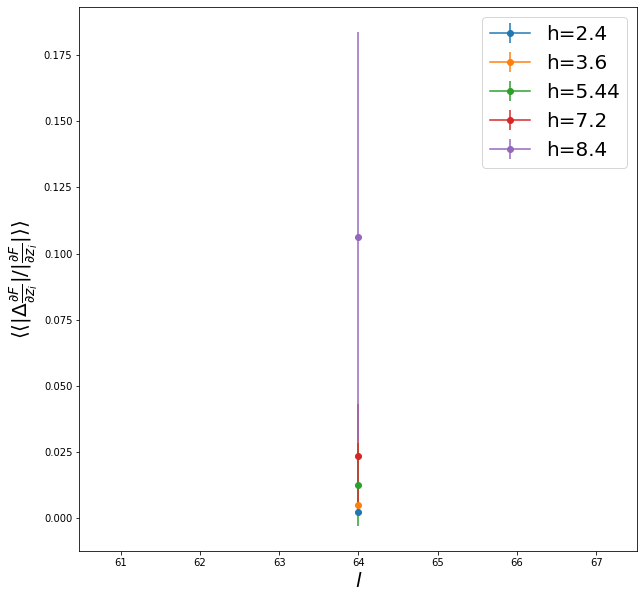

In [40]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'h={hs[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Finding the critical point computing the Hessian of the functional

#### Data

In [41]:
import torch                                                                                          
                                                                                                      
def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)    

ndata=100
f_xxs=[]
av_lambda_l=[]
fhh_l=[]
for j in trange(len(models_name)):
    print(hs[j])
    model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cuda",
            )
    avl=[]
    fhhl=[]
    for i in range(len(ls)):
        print(ls[i])
        data=np.load(data_path[j][i])
        m=data['density']
        av_lambda=0.
        av_f_hh=0.
        for idx in trange(ndata-1):
            x = m[idx:(idx+1)]
            x = torch.tensor(x, dtype=torch.double,device='cuda')
            x.requires_grad_(True)
            f_xx=hessian(model.functional(x),x).detach().cpu().numpy().reshape(ls[i],ls[i])
            lambd,_=np.linalg.eig(f_xx)
            av_f_hh=+np.average(1/np.abs(lambd))            
            lambd=np.min(lambd)
            av_lambda=+lambd            
        av_lambda=av_lambda/(ndata-1)
        av_f_hh=av_f_hh/(ndata-1)
        print(av_lambda,hs[j],ls[i])
        print(av_f_hh,hs[j],ls[i])
        avl.append(av_lambda)
        fhhl.append(av_f_hh)
    av_lambda_l.append(avl)
    fhh_l.append(fhhl)
    
            
                
        
        


  0%|          | 0/5 [00:00<?, ?it/s]

2.4
64


  0%|          | 0/99 [00:00<?, ?it/s]

0.0005180361091926039 2.4 64
0.14870823164938737 2.4 64
3.6
64


  0%|          | 0/99 [00:00<?, ?it/s]

0.0003874862142654918 3.6 64
0.13261626550997546 3.6 64
5.44
64


  0%|          | 0/99 [00:00<?, ?it/s]

0.00010484890555670198 5.44 64
0.11555039447268035 5.44 64
7.2
64


  0%|          | 0/99 [00:00<?, ?it/s]

0.00010808358945492458 7.2 64
0.08188305282184714 7.2 64
8.4
64


  0%|          | 0/99 [00:00<?, ?it/s]

-0.1585561330113186 8.4 64
0.03846455325861769 8.4 64


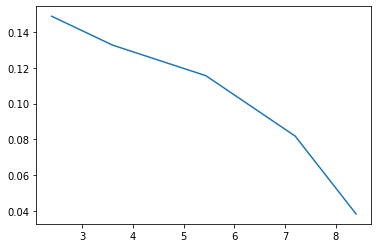

In [47]:

# for i in range(len(hs)-1):
#     plt.plot(ls,av_lambda_l[i],label=f'h={hs[i]}')
# plt.legend()
# plt.show()

for i in range(len(ls)):
    plt.plot(hs,[fhh_l[j][0]  for j in range(len(hs))])
plt.show()